# Artificial IntelligenceApplied toSatellite-based RemoteSensing Data for EarthObservation
## Chapter 7 - Example 3: Detection

The aim of this project is to implement a model able to detect simple object

Load the [NumPy](https://numpy.org/) library. NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

In [ ]:
import numpy as np

Load the [Matplotlib](https://matplotlib.org/) library. Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+. There is also a procedural "pylab" interface based on a state machine (like OpenGL), designed to closely resemble that of MATLAB, though its use is discouraged. SciPy makes use of Matplotlib.

In [ ]:
import matplotlib.pyplot as plt

Load some functions from Tensorflow.Keras library. Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import backend as K

## Create the dataset
For this simple project the dataset is created on-line. A common practice in Deep Learning is the use of generators. Basically a generator is composed of an infinite while loop and of the yield keyword. The generator is used to avoid memory problems, infact the datast is not loaded all in once, but batch by batch.

The generator, in this case, produces an RGB image of size (32, 32, 3) -> (width, height, channel), in which you can see a random object in a noisy background. The position of the objects is random.

In [ ]:
def dataset_generator(batch_size = 16):
  img_shape = (32, 32, 3)
  
  while True:
    x_train = np.zeros((batch_size, img_shape[0], img_shape[1], img_shape[2]))
    y_train = np.zeros((batch_size, 4))

    for b in range(batch_size):

      object_width = int(np.random.randint(4, high = 12, size = 1))
      object_height = int(np.random.randint(4, high = 12, size = 1)) 
      #object_height = object_width

      x = np.random.randint(object_width + 1, high = img_shape[0] - object_width - 1)
      y = np.random.randint(object_height + 1, high = img_shape[0] - object_height - 1)

      x_train[b, x:x+object_width, y:y+object_height, 1] = 1 
      x_train[b, ...] = x_train[b, ...] + np.random.random(img_shape)*0.2
      
      x_train = np.clip(x_train, 0.0, 1.0)

      y_train[b, 0] = x
      y_train[b, 1] = y
      y_train[b, 2] = x + object_width
      y_train[b, 3] = y + object_height
    
    yield x_train, y_train

In [ ]:
generator = dataset_generator(batch_size = 9)
itereator = iter(generator)
x_train, y_train = next(itereator)

In [ ]:
y_train

array([[12., 11., 22., 18.],
       [18., 17., 28., 22.],
       [19., 21., 26., 28.],
       [ 9., 14., 17., 22.],
       [14., 21., 21., 29.],
       [17., 24., 28., 28.],
       [ 8., 15., 14., 24.],
       [ 8., 17., 15., 27.],
       [16., 16., 26., 22.]])

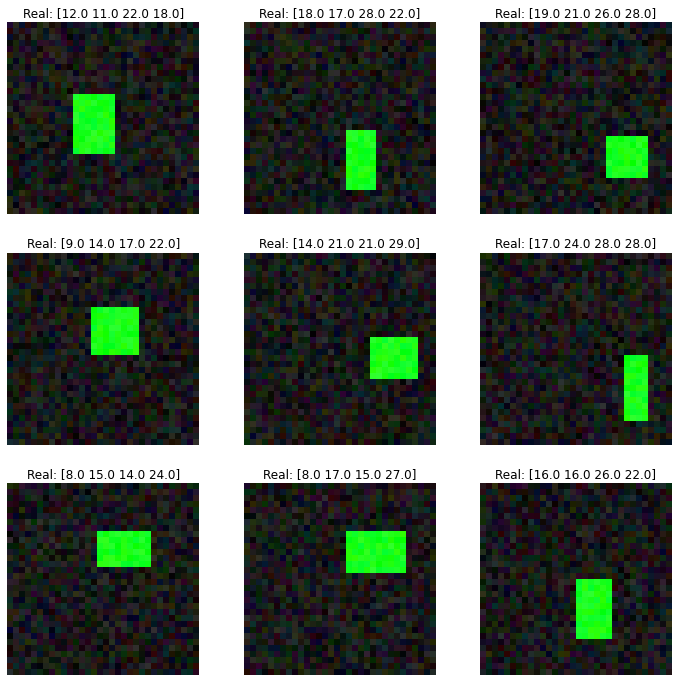

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (12, 12))

counter = 0
for i in range(3):
    for j in range(3):
        axes[i,j].imshow(x_train[counter,...])
        axes[i,j].set_title('Real: [%1.1f %1.1f %1.1f %1.1f]' % (y_train[counter,0], y_train[counter, 1], y_train[counter, 2], y_train[counter, 3]))
        axes[i,j].axis(False)
        counter = counter + 1

plt.show()

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64,  activation = 'relu'))
model.add(Dense(32,  activation = 'relu'))
model.add(Dense(4))

model.compile(loss='mae', optimizer = 'adam')

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1

In [ ]:
history = model.fit_generator(
    dataset_generator(32),
    steps_per_epoch=4000//32,
    validation_data=dataset_generator(16),
    validation_steps=1000//16,
    epochs = 100
)

Epoch 1/100
125/125 [==============================] - 4s 30ms/step - loss: 1.3262 - val_loss: 1.2324
Epoch 2/100
125/125 [==============================] - 4s 29ms/step - loss: 1.0790 - val_loss: 1.0140
Epoch 3/100
125/125 [==============================] - 4s 29ms/step - loss: 0.9641 - val_loss: 0.8399
Epoch 4/100
125/125 [==============================] - 4s 33ms/step - loss: 0.8892 - val_loss: 0.7788
Epoch 5/100
125/125 [==============================] - 4s 29ms/step - loss: 0.9014 - val_loss: 1.0991
Epoch 6/100
125/125 [==============================] - 3s 28ms/step - loss: 0.8605 - val_loss: 0.8893
Epoch 7/100
125/125 [==============================] - 4s 28ms/step - loss: 0.8286 - val_loss: 0.9200
Epoch 8/100
125/125 [==============================] - 4s 29ms/step - loss: 0.8160 - val_loss: 0.7936
Epoch 9/100
125/125 [==============================] - 4s 28ms/step - loss: 0.7784 - val_loss: 0.9420
Epoch 10/100
125/125 [==============================] - 4s 29ms/step - loss: 0.696

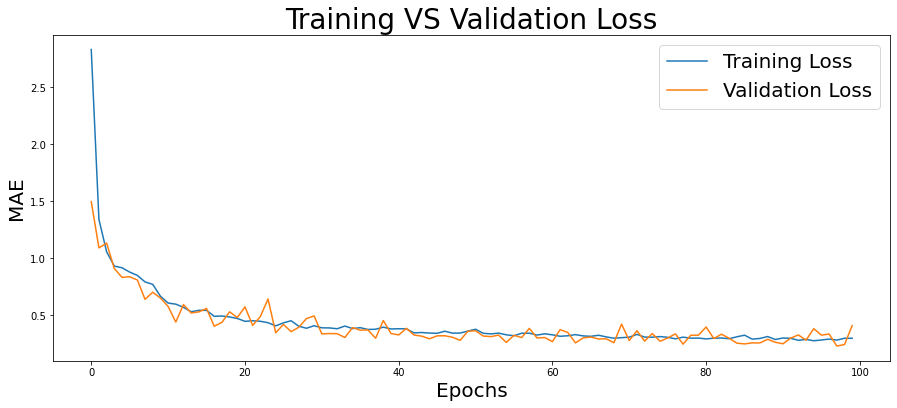

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 6))
ax.plot(history.history['loss'], label = 'Training Loss')
ax.plot(history.history['val_loss'], label = 'Validation Loss')

ax.set_title('Training VS Validation Loss', fontsize = 28)
ax.set_xlabel('Epochs', fontsize = 20)
ax.set_ylabel('MAE', fontsize = 20)
ax.legend(fontsize = 20)

plt.show()

In [ ]:
def round_int(x):
  last_Dig = int(str(x).split('.')[1][0]);
  n = 0
  
  if last_Dig >= 5:
    n = int(str(x).split('.')[0]) + 1
  else:
    n = int(str(x).split('.')[0])
  
  return n


In [ ]:
def bounding_box(coordinates):
  box = np.zeros((32, 32, 3))

  x1 = int(round_int(coordinates[0]))
  x2 = int(round_int(coordinates[1]))
  x3 = int(round_int(coordinates[2]))
  x4 = int(round_int(coordinates[3]))

  box[x1-1:x3+1, x2-1, 0] = 1
  box[x1-1:x3+1, x4, 0] = 1
  box[x1-1, x2-1:x4+1, 0] = 1
  box[x3, x2-1:x4+1, 0] = 1

  return box


In [ ]:
gen = iter(dataset_generator(16))
x_train, y_train = next(gen)
pred = model.predict(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


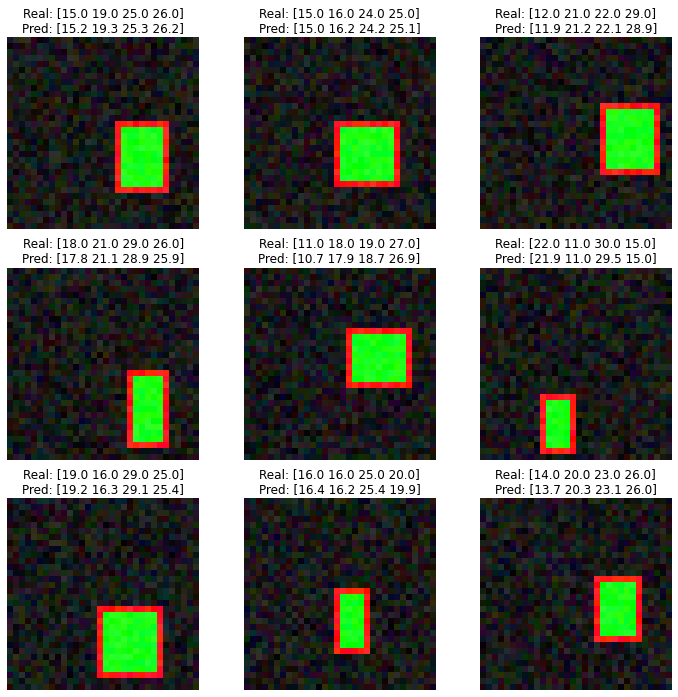

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (12, 12))

counter = 0
for i in range(3):
    for j in range(3):
        b = bounding_box(pred[counter, ...])
        axes[i,j].imshow(x_train[counter,...] + b)
        axes[i,j].set_title('Real: [%1.1f %1.1f %1.1f %1.1f]\nPred: [%1.1f %1.1f %1.1f %1.1f]'  
                            % (y_train[counter,0], y_train[counter, 1], y_train[counter, 2], y_train[counter, 3]
                               , pred[counter,0], pred[counter, 1], pred[counter, 2], pred[counter, 3]))
        axes[i,j].axis(False)
        counter = counter + 1

plt.show()